# Using ClusterFinderMT with Moench05

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

#Directly import what we need from aare
from aare import ClusterFileSink, ClusterFinderMT, ClusterFile, CtbRawFile
from aare.transform import moench05


base = Path('/mnt/sls_det_storage/moench_data/Julian/MOENCH05/20250113_first_xrays_redo/raw_files/')
cluster_file = Path('/home/l_msdetect/erik/tmp/Cu.clust')
pedestal_file = base/'moench05_noise_10_us_master_0.json'
data_file = base/'moench05_xray_10_us_master_0.json'


# We need to invert one of the variants,
roi = ((slice(0,80,1), slice(100,150,1)))      #region that we want to invert
bitmask = np.array([0x3FFF], dtype=np.uint16)  #Bits that should be inverted

# Having the slice of the region and the bitmask (14 ones) we can do the inversion with xor
# np.bitwise_xor(frame[roi], bitmask, out = frame[roi])

Example run on: **2025-01-22 11:08** with aare: **dev**

## Initialize the ClusterFinderMT with a pedestal

In [2]:
n_frames_pd = 1000
cluster_size = (3,3)
image_size = (160,150) #could also be read from master file


cf = ClusterFinderMT(image_size, cluster_size, n_sigma = 5, capacity = 2000, n_threads=48)

t0 = time.perf_counter()

with CtbRawFile(pedestal_file, transform=moench05) as f:
    for i in range(n_frames_pd):
        frame_number, frame = f.read_frame()
        np.bitwise_xor(frame[roi], bitmask, out = frame[roi])
        cf.push_pedestal_frame(frame)
cf.sync() #Wait until the input queue is empty, purely for timing

elapsed_t = time.perf_counter()-t0
print(f'Pedestal took: {elapsed_t:.3f}s')

Pedestal took: 0.632s


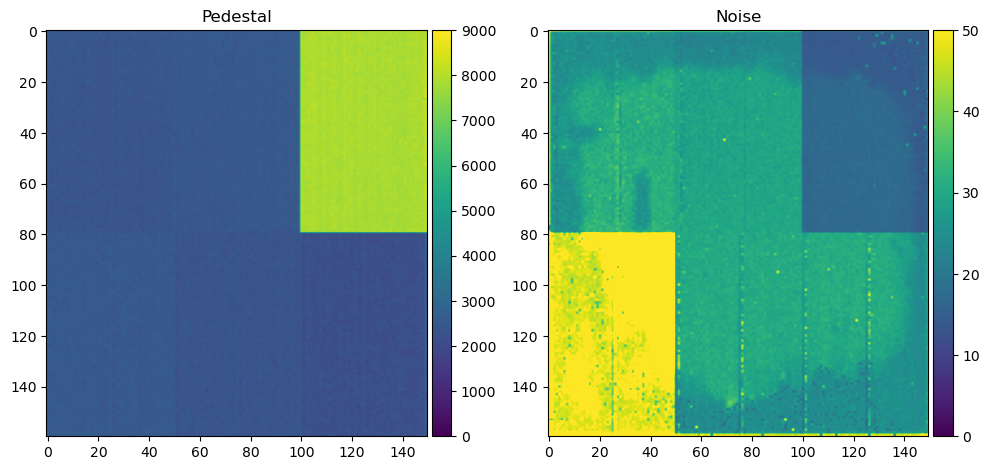

In [3]:
#Stop the MT cluster finder to read back pedestal and nosie from thread 19
cf.stop()
pd = cf.pedestal(19)
noise = cf.noise(19)
cf.start()

im = []

fig, axs = plt.subplots(1,2, figsize = (10,5))
im.append(axs[0].imshow(pd))
im[-1].set_clim(0,9000)
axs[0].set_title('Pedestal')


im.append(axs[1].imshow(noise))
im[-1].set_clim(0,50)
axs[1].set_title('Noise')

#Make sure the color bar has the same height as the image
for i,ax in enumerate(axs):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im[i], cax=cax)
fig.tight_layout()

## Run the clustering

- With ClusterFileSink we write to "Annas" cluster file format, but an in memory alternative can be used
- 48 threads are probably overkill if we read from disk

/mnt/sls_det_storage/moench_data/Julian/MOENCH05/20250113_first_xrays_redo/raw_files/moench05_xray_10_us_master_0.json


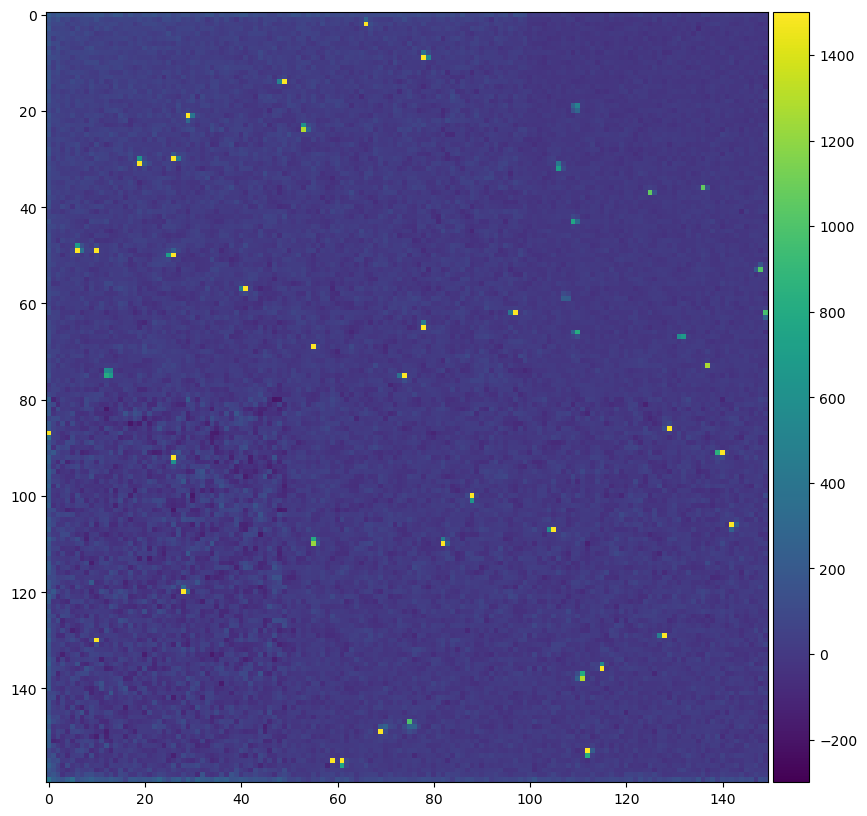

In [4]:
print(data_file)
with CtbRawFile(data_file, transform=moench05) as f:
    header, image = f.read_frame()
    np.bitwise_xor(image[roi], bitmask, out = image[roi])
    image = image-pd
    
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(image)
im.set_clim(-300,1500)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [6]:
N = 50000
n_skip = 100
t_start = time.perf_counter()
t0 = time.perf_counter()

#Connect a sink to the ClusterFinder, this will pull all clustered frames
#from the ClusterFinder and write them to a old style cluster file
sink = ClusterFileSink(cf, cluster_file)

with CtbRawFile(data_file, transform=moench05) as f:
    print(f'{f.frames_in_file=}')
    f.seek(n_skip) #skip the first n_skip frames to avoid temperature issues
    for i in range(f.frames_in_file-n_skip):
        header, frame = f.read_frame()
        np.bitwise_xor(frame[roi], bitmask, out = frame[roi])
        cf.find_clusters(frame, header['frameNumber'])
        

#once we are done with the processing we stop the ClusterFinderMT and the ClusterFileSink
#This would also be needed if we want to access data that is used by the processing threads
cf.stop()
sink.stop()

t_elapsed = time.perf_counter()-t0
print(f'Clustering (and writing to disk) {N} frames took {t_elapsed:.2f}s  {N/t_elapsed:.0f} FPS')


f.frames_in_file=100000
Clustering (and writing to disk) 50000 frames took 31.15s  1605 FPS


## Read back the data and fill a 3D histogram

- [row, col, ADU]

In [7]:
t0 = time.perf_counter()
offset= -0.5
hist3d = bh.Histogram(
    bh.axis.Regular(160, 0+offset, 160+offset),  #x
    bh.axis.Regular(150, 0+offset, 150+offset),  #y
    bh.axis.Regular(200, 0, 6000), #ADU
)

total_clusters = 0
with ClusterFile(cluster_file, chunk_size = 1000) as f:
    for i, clusters in enumerate(f):
        arr = np.array(clusters)
        total_clusters += clusters.size
        hist3d.fill(arr['y'],arr['x'], clusters.sum_2x2()) #python talks [row, col] cluster finder [x,y]

        
t_elapsed = time.perf_counter()-t0
print(f'Histogram filling took: {t_elapsed:.3f}s {total_clusters/t_elapsed/1e6:.3f}M clusters/s')

Histogram filling took: 0.432s 12.680M clusters/s


### Plot a histogram per region 

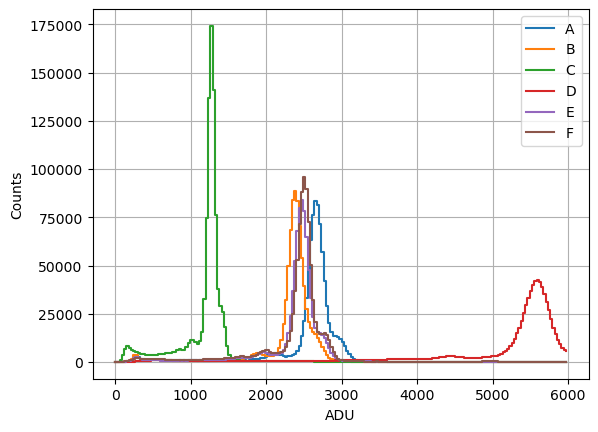

In [8]:
histogram_data = hist3d.counts()
x = hist3d.axes[2].edges[:-1]

variants = {
    'A': (slice(0,80,1), slice(0,50,1)),
    'B': (slice(0,80,1), slice(50,100,1)),
    'C': (slice(0,80,1), slice(100,150,1)), #This is the region that was inverted
    'D': (slice(80, 160,1), slice(0,50,1)),
    'E': (slice(80, 160,1), slice(50,100,1)),
    'F': (slice(80, 160,1), slice(100,150,1)),
}



fig, ax = plt.subplots()

for label, reg in variants.items():
    counts = histogram_data[reg].sum(axis =0).sum(axis = 0)
    ax.step(hist3d.axes[2].edges[:-1], counts, where="post", label = label);
ax.set_xlabel('ADU')
ax.set_ylabel('Counts')
ax.legend()
ax.grid()

### Hitmap

(160, 150)


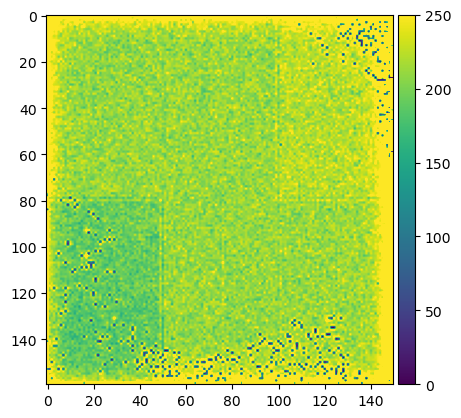

In [9]:
# Project the histogram, showing number of clusters per pixel
# i.e. "hitmap"
img = hist3d.values().sum(axis = 2)
fig, ax = plt.subplots()
im = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
im.set_clim(0,250)
print(img.shape)

[5970.    0.    0.]


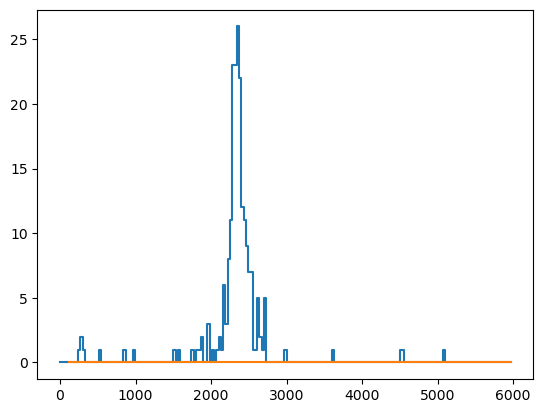

In [13]:
from aare import fit_gaus, gaus
y = histogram_data[100,100,:]
xx = np.linspace(x[0], x[-1])
fig, ax = plt.subplots()
ax.step(x, y, where = 'post')

par = fit_gaus(x, y)
ax.plot(xx, gaus(xx,par))
print(par)

In [11]:
gaus(xx,(1,1,1))

array([0.60653066, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])